<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install dataretrieval
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from scipy.stats import linregress

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Pair gage ids with effective width point ids

In [5]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Load in-situ widths from USGS

In [6]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    # ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

gage_width_m
site_no  date                    
06801000 2019-10-08    405.487805
         2021-07-12    402.439024
         2019-10-08    405.487805
         2022-06-07    378.048780
         2022-05-02    396.341463
...                           ...
06775900 2025-08-25     12.804878
         2025-08-25     12.804878
         2025-08-25     12.804878
         2025-09-02     13.414634
         2025-09-02     13.414634

[1234 rows x 1 columns]

Discharge

In [34]:
sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']

# first and last dates same as for in situ widths
start = str(isw.index.sortlevel(1)[0][0][1])
end = str(isw.index.sortlevel(1)[0][-1][1])

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms'})
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms
site_no  date                  
06620000 2007-11-19    3.967405
         2007-11-20    3.740696
         2007-11-21    3.485648
         2007-11-22    3.230601
         2007-11-23    2.862199
...                         ...
06805500 2025-08-30  123.556318
         2025-08-31  127.523723
         2025-09-01  181.367072
         2025-09-02  459.085402
         2025-09-03  385.405029

[38994 rows x 1 columns]

Join in-situ width and discharge to build rating curves

In [39]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  gage_width_m      logw      logQ
site_no  date                                                    
06620000 2011-08-22   11.392119     46.951220  1.671647  1.056605
         2011-10-12    6.206155     46.951220  1.671647  0.792823
         2012-01-30    3.825712     39.634146  1.598070  0.582712
         2012-03-30   17.173195     47.865854  1.680026  1.234851
         2012-06-22    4.279129     37.804878  1.577548  0.631355
...                         ...           ...       ...       ...
06805500 2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-08-12  253.347129    378.048780  2.577548  2.403716
         2025-08-27  121.856002    378.048780  2.577548  2.085847

[1219 rows x 4 columns]

Text(0.02, 0.5, 'Gage width (m)')

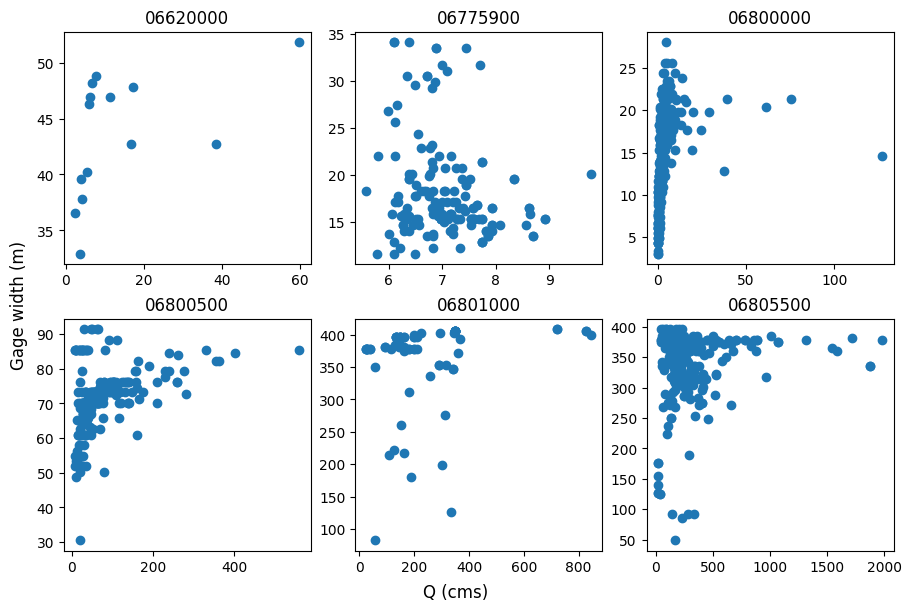

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Text(0.5, 0.98, 'Power law w/Q rating curves')

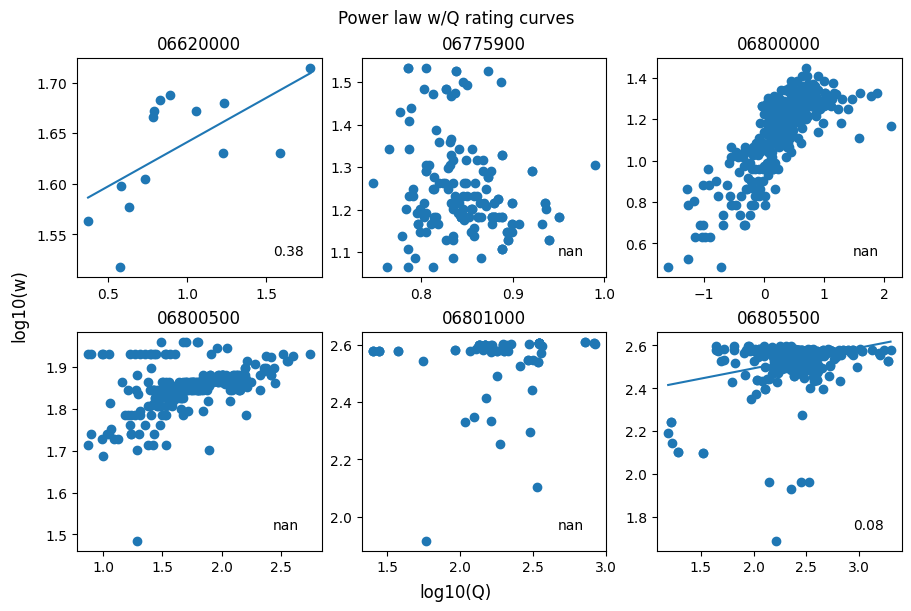

In [37]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [10]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06801000,0.087846,1.553382,0.383412,35.758761
06805500,-0.528364,1.692555,0.042450,49.266824
06800000,0.275466,1.072538,0.616820,11.817848
06800500,0.068638,1.732994,0.186642,54.074626
06620000,0.031141,2.477969,0.008993,300.585898
06775900,0.095966,2.301501,0.078646,200.216932


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [30]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  rc_width_m  gage_width_m
site_no  date                                            
06620000 2007-11-19    3.967405  313.766556           NaN
         2007-11-20    3.740696  313.192153           NaN
         2007-11-21    3.485648  312.504170           NaN
         2007-11-22    3.230601  311.765574           NaN
         2007-11-23    2.862199  310.592282           NaN
...                         ...         ...           ...
06805500 2025-08-30  123.556318    3.866243           NaN
         2025-08-31  127.523723    3.802216           NaN
         2025-09-01  181.367072    3.156562           NaN
         2025-09-02  459.085402    1.932443           NaN
         2025-09-03  385.405029    2.119580           NaN

[39189 rows x 3 columns]

Text(0.5, 0.98, 'Rating curve validation')

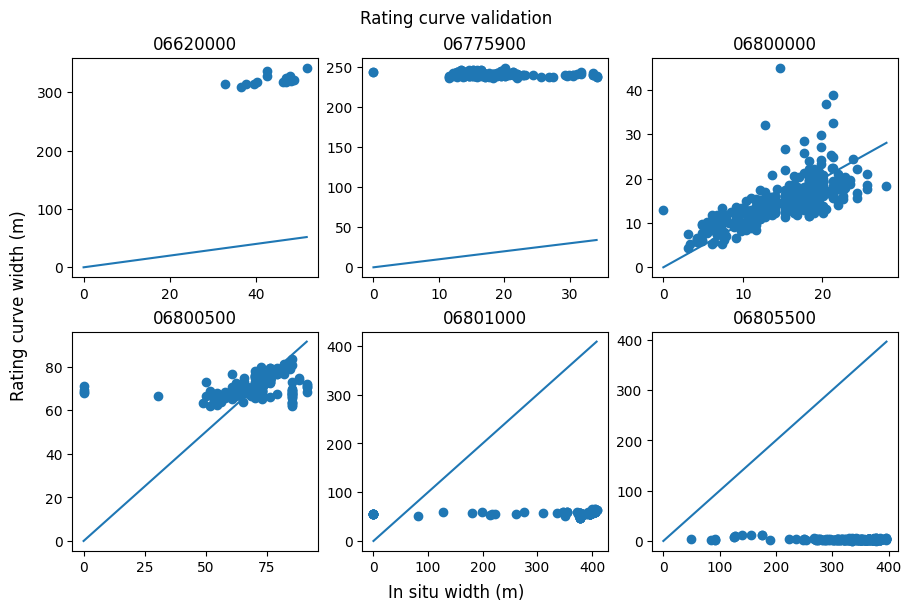

In [31]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

Load in effective width\
See stac_processing_download.ipynb

In [41]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[allwidths.n_valid == allwidths.n_pixels]

allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version
0,0,S2B_15TTF_20181229_0_L2A,246043,760,760,16,0,752,15TTF,2018-12-29,0
4,4,S2B_15TTF_20181229_0_L2A,246016,1892,1892,0,0,1792,15TTF,2018-12-29,0
6,6,S2B_15TTF_20181229_0_L2A,246048,1797,1797,22,11,1778,15TTF,2018-12-29,0
7,7,S2B_15TTF_20181229_0_L2A,201625,45736,45736,13965,22851,12294,15TTF,2018-12-29,0
8,8,S2B_14TPM_20181229_0_L2A,120725,164,164,65,22,136,14TPM,2018-12-29,0
...,...,...,...,...,...,...,...,...,...,...,...
1783,1783,S2B_15TTF_20240102_0_L2A,246043,760,760,194,0,0,15TTF,2024-01-02,0
1784,1784,S2B_15TTF_20240102_0_L2A,153085,29425,29425,7011,0,0,15TTF,2024-01-02,0
1787,1787,S2B_15TTF_20240102_0_L2A,246016,1892,1892,401,0,0,15TTF,2024-01-02,0
1789,1789,S2B_15TTF_20240102_0_L2A,246048,1797,1797,284,0,0,15TTF,2024-01-02,0


AWS S2 STAC holds duplicate versions of some images with different versions of the processing baseline. Identify tiles and dates with multiple images and select the one with the most up to date processing baseline.

In [42]:
tile_dts = []
tile_dt_versions = []
for row in tqdm(allwidths.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))

tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version']).sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = (temp_df.head(1))
    nonduplicates.append(df_out)


nonduplicates = pd.concat(nonduplicates)
nonduplicates

13598it [00:00, 21721.63it/s]
100%|██████████| 2304/2304 [00:05<00:00, 441.34it/s]


,index,mgrs,date,version
0,1544,15TTF,2018-05-30,1
0,858,13TCF,2021-04-01,0
0,20,14TPM,2024-01-19,0
0,1818,14TQL,2022-08-02,0
0,1226,15TTG,2022-02-26,0
...,...,...,...,...
0,2615,14TLM,2024-02-24,0
0,132,15TTG,2020-06-28,1
0,3114,14TLM,2022-07-14,0
0,2465,14TQM,2022-03-15,0


Join nonduplicate images with widths and gage ids

In [60]:
nondup_widths = pd.merge(allwidths, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
nondup_widths = pd.merge(nondup_widths, gage_pts, how='left', on='iindex')
nondup_widths = nondup_widths.rename(columns={'gage_id': 'site_no'})
nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version,site_no,riv_length
0,1608,S2B_15TTF_20180530_1_L2A,153085,29425,29425,6672,3134,0,15TTF,2018-05-30,1,06801000,2096.250518
1,1609,S2B_15TTF_20180530_1_L2A,246043,760,760,213,55,0,15TTF,2018-05-30,1,06800500,372.624481
2,1610,S2B_15TTF_20180530_1_L2A,202726,26397,26397,2786,12673,0,15TTF,2018-05-30,1,06805500,1963.046231
3,1611,S2B_15TTF_20180530_1_L2A,202446,31634,31634,10295,306,0,15TTF,2018-05-30,1,06805500,2159.170932
4,1612,S2B_15TTF_20180530_1_L2A,203066,104240,104240,16097,34988,0,15TTF,2018-05-30,1,06805500,3946.934401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,1326,S2A_14TQM_20220315_0_L2A,120748,42,42,13,0,0,14TQM,2022-03-15,0,06800000,64.253559
10014,1327,S2A_14TQM_20220315_0_L2A,120445,42,42,10,0,0,14TQM,2022-03-15,0,06800000,76.595306
10015,2767,S2A_14TPM_20190123_0_L2A,120725,164,164,19,58,0,14TPM,2019-01-23,0,06800000,148.276448
10016,2768,S2A_14TPM_20190123_0_L2A,120748,42,42,6,10,0,14TPM,2019-01-23,0,06800000,64.253559


Calculate effective width and fractions of cloud and snow

In [61]:
nondup_widths['sat_width_m'] = nondup_widths.n_river * 100 / nondup_widths.riv_length
nondup_widths['fraction_cloud'] = nondup_widths.n_cloud / nondup_widths.n_pixels
nondup_widths['fraction_snow'] = nondup_widths.n_snow / nondup_widths.n_pixels
nondup_widths = nondup_widths.set_index(['site_no', 'date'])
nondup_widths

Unnamed: 0                    img_id  iindex  n_pixels  \
site_no  date                                                                 
06801000 2018-05-30        1608  S2B_15TTF_20180530_1_L2A  153085     29425   
06800500 2018-05-30        1609  S2B_15TTF_20180530_1_L2A  246043       760   
06805500 2018-05-30        1610  S2B_15TTF_20180530_1_L2A  202726     26397   
         2018-05-30        1611  S2B_15TTF_20180530_1_L2A  202446     31634   
         2018-05-30        1612  S2B_15TTF_20180530_1_L2A  203066    104240   
...                         ...                       ...     ...       ...   
06800000 2022-03-15        1326  S2A_14TQM_20220315_0_L2A  120748        42   
         2022-03-15        1327  S2A_14TQM_20220315_0_L2A  120445        42   
         2019-01-23        2767  S2A_14TPM_20190123_0_L2A  120725       164   
         2019-01-23        2768  S2A_14TPM_20190123_0_L2A  120748        42   
         2019-01-23        2769  S2A_14TPM_20190123_0_L2A  120445        42   

                     n_valid  n_river  n_cloud  n_snow   mgrs version  \
site_no  date                                                           
06801000 2018-05-30    29425     6672     3134       0  15TTF       1   
06800500 2018-05-30      760      213       55       0  15TTF       1   
06805500 2018-05-30    26397     2786    12673       0  15TTF       1   
         2018-05-30    31634    10295      306       0  15TTF       1   
         2018-05-30   104240    16097    34988       0  15TTF       1   
...                      ...      ...      ...     ...    ...     ...   
06800000 2022-03-15       42       13        0       0  14TQM       0   
         2022-03-15       42       10        0       0  14TQM       0   
         2019-01-23      164       19       58       0  14TPM       0   
         2019-01-23       42        6       10       0  14TPM       0   
         2019-01-23       42       11        6       0  14TPM       0   

                      riv_length  sat_width_m  fraction_cloud  fraction_snow  
site_no  date                                                                 
06801000 2018-05-30  2096.250518   318.282569        0.106508            0.0  
06800500 2018-05-30   372.624481    57.162106        0.072368            0.0  
06805500 2018-05-30  1963.046231   141.922282        0.480092            0.0  
         2018-05-30  2159.170932   476.803381        0.009673            0.0  
         2018-05-30  3946.934401   407.835509        0.335649            0.0  
...                          ...          ...             ...            ...  
06800000 2022-03-15    64.253559    20.232342        0.000000            0.0  
         2022-03-15    76.595306    13.055630        0.000000            0.0  
         2019-01-23   148.276448    12.813903        0.353659            0.0  
         2019-01-23    64.253559     9.338004        0.238095            0.0  
         2019-01-23    76.595306    14.361193        0.142857            0.0  

[10018 rows x 14 columns]

In [67]:
isw.join(nondup_widths, how='inner').to_csv('/content/drive/MyDrive/effwidth_results/gage_sites/sameday_sat_gage_width.csv')

In [70]:
Q.join(nondup_widths, how='inner')

Q_cms  Unnamed: 0                    img_id  iindex  \
site_no  date                                                                   
06620000 2018-01-02    3.457310        2166  S2B_13TCF_20180102_1_L2A   41930   
         2018-01-02    3.457310        2167  S2B_13TCF_20180102_1_L2A   41913   
         2018-01-02    3.457310        2168  S2B_13TCF_20180102_1_L2A   41900   
         2018-01-22    3.599003        2112  S2B_13TCF_20180122_0_L2A   41930   
         2018-01-22    3.599003        2113  S2B_13TCF_20180122_0_L2A   41913   
...                         ...         ...                       ...     ...   
06805500 2024-12-19  155.862328          33  S2A_14TQL_20241219_0_L2A  202446   
         2024-12-19  155.862328          34  S2A_14TQL_20241219_0_L2A  203066   
         2024-12-19  155.862328          41  S2A_15TTF_20241219_0_L2A  202726   
         2024-12-19  155.862328          42  S2A_15TTF_20241219_0_L2A  202446   
         2024-12-19  155.862328          43  S2A_15TTF_20241219_0_L2A  203066   

                     n_pixels  n_valid  n_river  n_cloud  n_snow   mgrs  \
site_no  date                                                             
06620000 2018-01-02        41       41       21        0      41  13TCF   
         2018-01-02       164      164       47        0     164  13TCF   
         2018-01-02       163      163       51        0     163  13TCF   
         2018-01-22        41       41       24        0      41  13TCF   
         2018-01-22       164      164       38        0     164  13TCF   
...                       ...      ...      ...      ...     ...    ...   
06805500 2024-12-19     31625    31625     6559        0       0  14TQL   
         2024-12-19    104191   104191    14831        0       0  14TQL   
         2024-12-19     26397    26397     7152        0       0  15TTF   
         2024-12-19     31634    31634     6546        0       0  15TTF   
         2024-12-19    104240   104240    14890        0       0  15TTF   

                    version   riv_length  sat_width_m  fraction_cloud  \
site_no  date                                                           
06620000 2018-01-02       1    86.932041    24.156801             0.0   
         2018-01-02       1   142.907272    32.888459             0.0   
         2018-01-02       1   140.711919    36.244265             0.0   
         2018-01-22       0    86.932041    27.607772             0.0   
         2018-01-22       0   142.907272    26.590669             0.0   
...                     ...          ...          ...             ...   
06805500 2024-12-19       0  2159.170932   303.774004             0.0   
         2024-12-19       0  3946.934401   375.759982             0.0   
         2024-12-19       0  1963.046231   364.331715             0.0   
         2024-12-19       0  2159.170932   303.171921             0.0   
         2024-12-19       0  3946.934401   377.254813             0.0   

                     fraction_snow  
site_no  date                       
06620000 2018-01-02            1.0  
         2018-01-02            1.0  
         2018-01-02            1.0  
         2018-01-22            1.0  
         2018-01-22            1.0  
...                            ...  
06805500 2024-12-19            0.0  
         2024-12-19            0.0  
         2024-12-19            0.0  
         2024-12-19            0.0  
         2024-12-19            0.0  

[10018 rows x 15 columns]

Join rating curve width, gage width, and sat width on date

In [68]:
alldata = pd.merge(Q, nondup_widths, how='outer', right_on=['date', 'site_'], left_on=['date', 'site_no'])
alldata = alldata.set_index(['site_no', 'date'])
alldata

KeyError: 'gage_id'

In [94]:
gage_avg_ew = alldata.groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
gage_avg_ew = gage_avg_ew.loc[gage_avg_ew.mean_sat_width_m >= 0]
gage_avg_ew = gage_avg_ew
gage_avg_ew

,site_no,date,mean_sat_width_m
0,06620000,2018-01-02,31.096508
1,06620000,2018-01-22,18.066147
2,06620000,2018-02-11,13.234994
3,06620000,2018-02-16,4.799286
4,06620000,2018-03-03,23.050391
...,...,...,...
1839,06805500,2024-10-25,362.019968
1840,06805500,2024-11-19,424.135912
1841,06805500,2024-12-04,339.524040
1842,06805500,2024-12-09,423.405994


How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

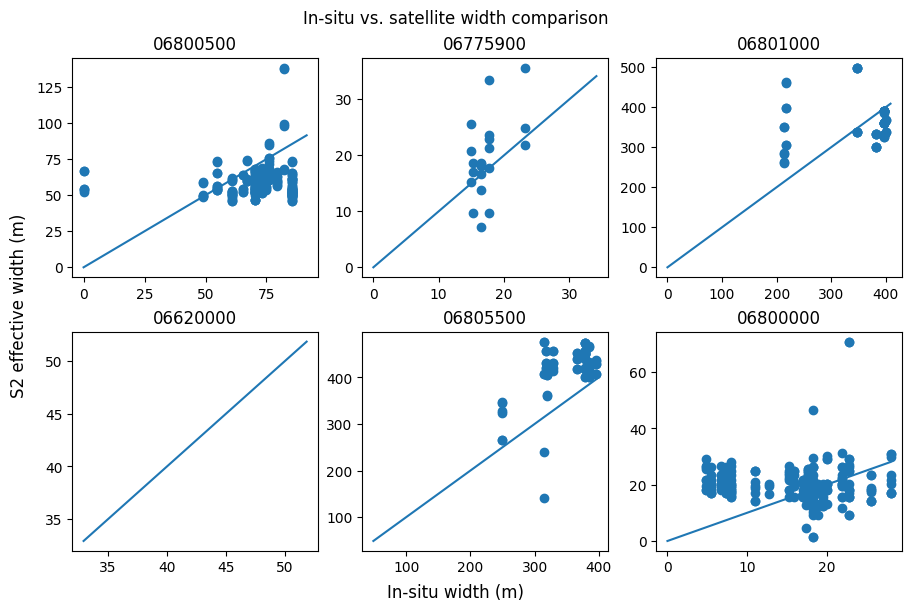

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in gage_avg_ew.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')

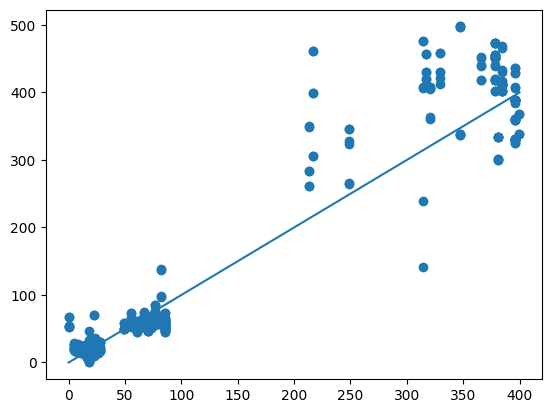

In [ ]:
fig, ax = plt.subplots()
sameday = alldata.loc[alldata.gage_width_m != None]
ax.scatter(sameday.gage_width_m, sameday.sat_width_m)
unity = np.linspace(0, 400)
ax.plot(unity, unity)

In [ ]:
unity

array([59.13773316, 59.8441198 , 60.55050643, 61.25689307, 61.9632797 ,
       62.66966634, 63.37605297, 64.08243961, 64.78882624, 65.49521288,
       66.20159951, 66.90798615, 67.61437278, 68.32075942, 69.02714605,
       69.73353269, 70.43991932, 71.14630596, 71.85269259, 72.55907923,
       73.26546586, 73.9718525 , 74.67823913, 75.38462577, 76.0910124 ,
       76.79739904, 77.50378567, 78.21017231, 78.91655894, 79.62294558,
       80.32933222, 81.03571885, 81.74210549, 82.44849212, 83.15487876,
       83.86126539, 84.56765203, 85.27403866, 85.9804253 , 86.68681193,
       87.39319857, 88.0995852 , 88.80597184, 89.51235847, 90.21874511,
       90.92513174, 91.63151838, 92.33790501, 93.04429165, 93.75067828])